In [8]:
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import glob

from statsmodels.formula.api import ols

# Load network stats
networks = pd.read_csv('networks/many_files_stats_cleaned.csv', sep=',', index_col='test')
networks['log n'] = np.log(networks['n'])
networks['log max_deg'] = np.log(networks['max_deg'])
networks['log avg_deg'] = np.log(networks['avg_deg'])

networks = networks.sort_values('n')

# Load wcol stats

dframes = []
for filename in glob.glob('networks/best_wcols/*.csv'):
    print(filename)
    dframes.append(pd.read_csv(filename, sep=',', index_col='test'))

wcol = pd.concat(dframes)

# There's some spurious file endings in that file
wcol.index = wcol.index.map(lambda s: s.split('.')[0])

networks = networks[~networks.index.duplicated(keep='first')]

# Merge into networks, drop networks w/o wcol stats
for r in range(1,6):
    column = wcol[wcol['rad']==r]['sortdeg1.lsR']
    column = column[~column.index.duplicated(keep='first')]
    networks['wcol'+str(r)] = column
    
networks = networks.dropna()
print("Loaded data for {} networks".format(len(networks)))
networks.head(5)

networks/best_wcols/big-konect_rep.csv
networks/best_wcols/big-corpus_rep.csv
networks/best_wcols/huge-konect_rep.csv
networks/best_wcols/big-network-repo_rep.csv
networks/best_wcols/le_7000-network-repo_rep.csv
networks/best_wcols/big-colours_rep.csv
networks/best_wcols/small-corpus_rep.csv
networks/best_wcols/small-network-repo_rep.csv
networks/best_wcols/medium-konect_rep.csv
networks/best_wcols/medium-colours_rep.csv
networks/best_wcols/medium-corpus_rep.csv
networks/best_wcols/small-konect_rep.csv
networks/best_wcols/medium-network-repo_rep.csv
networks/best_wcols/small-colours_rep.csv
Loaded data for 1675 networks


,n,m,avg_deg,max_deg,log n,log max_deg,log avg_deg,wcol1,wcol2,wcol3,wcol4,wcol5
test,,,,,,,,,,,,
Trec3,2,1,1.00000,1,0.693147,0.000000,0.000000,2.0,2.0,2.0,2.0,2.0
Trec4,3,2,1.33333,2,1.098612,0.693147,0.287680,2.0,2.0,2.0,2.0,2.0
out,5,8,3.20000,4,1.609438,1.386294,1.163151,28.0,228.0,519.0,732.0,873.0
myciel2,5,5,2.00000,2,1.609438,0.693147,0.693147,3.0,4.0,4.0,4.0,4.0
cage3,5,7,2.80000,4,1.609438,1.386294,1.029619,3.0,4.0,4.0,4.0,4.0


<h2>Read improved results based on coloring number</h2>

<h2>Define helpers for plotting</h2>

In [2]:

latex_label = {'n': '$n$', 'log n': '$\\log n$', 'm': '$m$', 'log m': '$\\log m$',
                'avg_deg': '$\\bar d$', 'max_deg': '$\\Delta$', 
                'log avg_deg': '$\\log \\bar d$', 'log max_deg': '$\\log \\Delta$',
                'radius': '$r$'}
for r in range(1,6):
    latex_label['wcol'+str(r)] = '$\\mathrm{wcol}_'+str(r)+'$'

    
# Helper function for regression plot w/ outliers
def label_point(x, y, val, ax, label_align='left'):
    import matplotlib.transforms as mtrans
    # This translation is on screen-space, not data-space. 
    # Hence we can enter values in pixels.
    if label_align == 'left':
        trans = mtrans.Affine2D().translate(10, 0)
    else:
        trans = mtrans.Affine2D().translate(-10, 0)
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        label = ax.text(point['x'], point['y'], str(point['val']), ha=label_align)
        label.set_transform(label.get_transform() + trans)

def regplot(tab, xlabel, ylabel, legend="upper left", axis=None, label_pos='left'):
    x,y,labels = tab[xlabel], tab[ylabel], tab.index

    sns.set_style("whitegrid")

    regression = ols("data ~ x", data=dict(data=y, x=x)).fit()
    intercept = regression.params['Intercept']
    slope = regression.params['x']

#     tab = tab.join(regression.outlier_test())
    
#     outliers = tab.loc[np.abs(tab['student_resid']) > 2 ].copy()
#     outliers['name'] = outliers.index
#     ox,oy,olabels = outliers[xlabel], outliers[ylabel], outliers['name']

    if not axis:
        axis = plt.gca()
    
    sns.regplot(x, y, marker='+', ax=axis, line_kws={
                'color': 'gray',
                'label':"y={0:.2f}x {1:+.2f}".format(slope,intercept)
                })
    axis.legend(loc=legend)
    
    axis.set_xlabel(latex_label[xlabel], fontsize=14)
    axis.set_ylabel(latex_label[ylabel], fontsize=14)
    
    # Label outliers
#     if label_pos == 'left':
#         label_align = 'right'
#     else:
#         label_align = 'left'
#     label_point(ox,oy,olabels, axis, label_align=label_align)
    
#     return slope, intercept, outliers['name'].tolist()

In [3]:
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def colorline(
    x, y, z=None, axis=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=1, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)
    
    if not axis:
        axis = plt.gca()
    axis.add_collection(lc)

    return lc

<h2>Compute correlation matrix</h2>

In [4]:
tab = networks.copy().drop('log avg_deg', axis=1)

labels = tab.columns.tolist()

cols = labels[:-5]
rows = labels[-5:]

cols = [latex_label[s] for s in cols]
rows = [latex_label[s] for s in rows]

print(cols)
print(rows)

# Rows should be wcol1,...,wcol5; columns all other measures

M = pd.DataFrame(np.corrcoef(tab.T), columns=cols+rows, index=cols+rows)

# We are only interested into basic measures vs. wcols
M = M[cols].loc[rows]
M = M[['$n$', '$m$', '$\\Delta$', '$\\bar d$',]]

['$n$', '$m$', '$\\bar d$', '$\\Delta$', '$\\log n$', '$\\log \\Delta$']
['$\\mathrm{wcol}_1$', '$\\mathrm{wcol}_2$', '$\\mathrm{wcol}_3$', '$\\mathrm{wcol}_4$', '$\\mathrm{wcol}_5$']


Let's plot it.

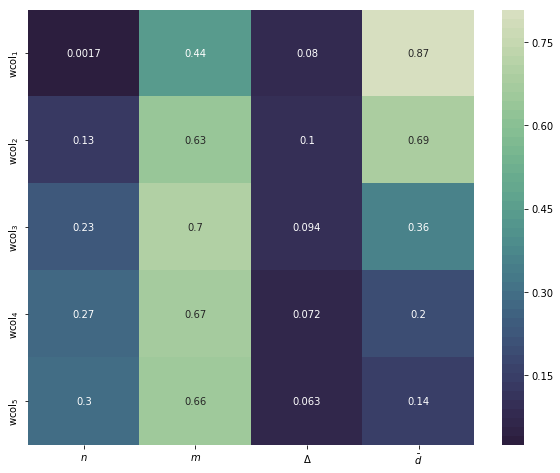

In [9]:
plt.figure(figsize=(10,8))
palette = sns.cubehelix_palette(48, reverse=True, start=.5, rot=-.75)

sns.heatmap(M, cmap=palette, robust=True, annot=True)
# plt.savefig('wcol_correlation.pdf')
# plt.savefig('wcol_correlation.svg')

In [15]:
import matplotlib
C = M.loc[['$\\mathrm{wcol}_1$', '$\\mathrm{wcol}_3$', '$\\mathrm{wcol}_5$']]

# C.apply(cmap
cmap = matplotlib.colors.ListedColormap(palette)
C = C.applymap(cmap)

$\mathrm{wcol}_1$ $n$         (0.17250549177124488, 0.11951843162770594, 0.2...
$m$         (0.2958858732022419, 0.532095403269888, 0.5458...
$\Delta$    (0.19865285861307697, 0.16624273677952897, 0.3...
$\bar d$    (0.6960179039777673, 0.815760580175503, 0.6425...
Name: $\mathrm{wcol}_1$, dtype: object
$\mathrm{wcol}_3$ $n$         (0.23792769775695657, 0.32348811191132143, 0.4...
$m$         (0.49868537221142645, 0.7301318611240792, 0.57...
$\Delta$    (0.2060280204852557, 0.1845969384637609, 0.337...
$\bar d$    (0.2648480952652099, 0.45142307255741476, 0.52...
Name: $\mathrm{wcol}_3$, dtype: object
$\mathrm{wcol}_5$ $n$         (0.24886020681613036, 0.3845822677889713, 0.50...
$m$         (0.4519984101487008, 0.7021500032770456, 0.562...
$\Delta$    (0.19865285861307697, 0.16624273677952897, 0.3...
$\bar d$    (0.21805042635421357, 0.22328637568306292, 0.3...
Name: $\mathrm{wcol}_5$, dtype: object


<h2>Plot measures against $wcol_1$, $wcol_3$, $wcol_5$</h2>

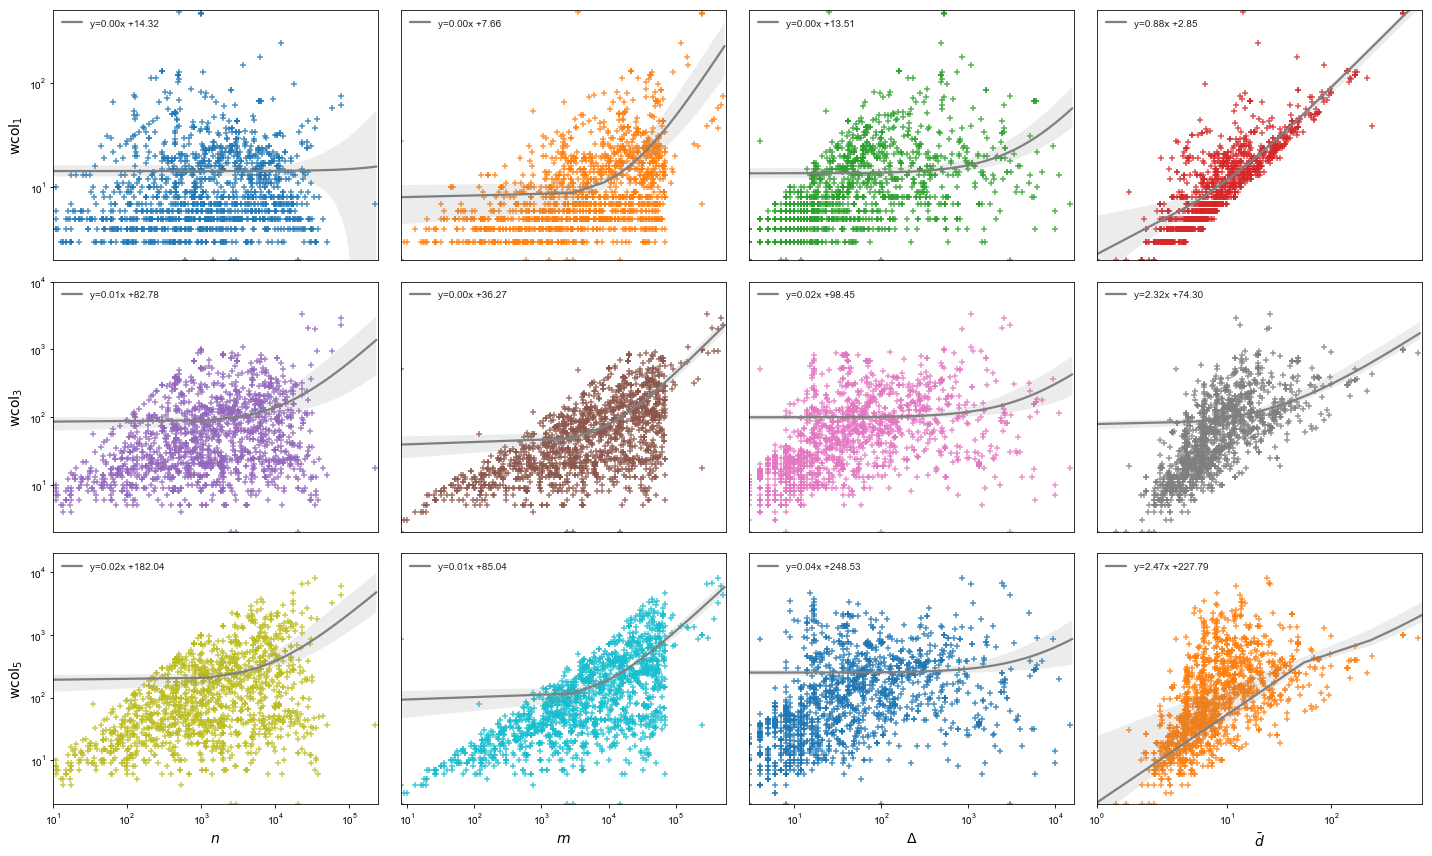

In [16]:
f, axes = plt.subplots(3, 4, figsize=(20,12))

sns.set_palette(sns.color_palette("Set1", 4), 4)

max_n = np.max(networks['n']) * 1.1
max_m = np.max(networks['m']) * 1.1
max_maxdeg = np.max(networks['max_deg']) * 1.1
max_avgdeg = np.max(networks['avg_deg']) * 1.1


colors = [c for _, c in C.iterrows()]
wcolsteps = ['wcol1','wcol3','wcol5']
ylims = [500,10000,20000]
inner = [True, True, False]
for wcollabel,ax_row,top,is_inner in zip(wcolsteps,axes,ylims,inner):
    (ax1,ax2,ax3,ax4) = ax_row
    regplot(networks, 'n', wcollabel, axis=ax1)
    ax1.set_xscale('symlog')
    ax1.set_yscale('symlog')
    ax1.set_xlim(left=10, right=max_n)
    ax1.set_ylim(bottom=2, top=top)
    ax1.grid(False)
    
    regplot(networks, 'm', wcollabel, axis=ax2)
    ax2.set_xscale('symlog')
    ax2.set_yscale('symlog')
    ax2.set_xlim(left=8, right=max_m)
    ax2.set_ylim(bottom=2, top=top)
    ax2.grid(False)    
    
    regplot(networks, 'max_deg', wcollabel, axis=ax3)
    ax3.set_xscale('symlog')
    ax3.set_yscale('symlog')
    ax3.set_xlim(left=3, right=max_maxdeg)
    ax3.set_ylim(bottom=2, top=top)
    ax3.grid(False)

    regplot(networks, 'avg_deg', wcollabel, axis=ax4)
    ax4.set_xscale('symlog')
    ax4.set_yscale('symlog')
    ax4.set_xlim(left=1, right=max_avgdeg)
    ax4.set_ylim(bottom=2, top=top)
    ax4.grid(False)
    
    for ax in ax_row[1:]:
        ax.get_yaxis().set_visible(False)
    
    if not is_inner:
        continue
        
    for ax in ax_row:
        ax.get_xaxis().set_visible(False)

f.tight_layout()
f.savefig('stats_vs_wcol.svg')
f.savefig('stats_vs_wcol.pdf')

['$n$', '$m$', '$\\bar d$', '$\\Delta$', '$\\log n$', '$\\log \\Delta$']
['$\\mathrm{wcol}_1$', '$\\mathrm{wcol}_2$', '$\\mathrm{wcol}_3$', '$\\mathrm{wcol}_4$', '$\\mathrm{wcol}_5$']


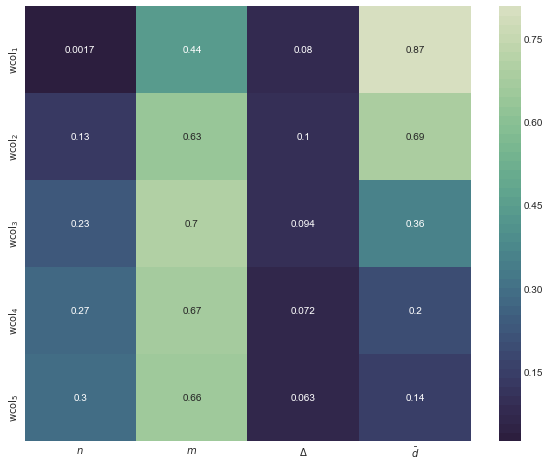

In [6]:
tab = networks.copy().drop('log avg_deg', axis=1)

labels = tab.columns.tolist()

cols = labels[:-5]
rows = labels[-5:]

cols = [latex_label[s] for s in cols]
rows = [latex_label[s] for s in rows]

print(cols)
print(rows)

# Rows should be wcol1,...,wcol5; columns all other measures

M = pd.DataFrame(np.corrcoef(tab.T), columns=cols+rows, index=cols+rows)

# We are only interested into basic measures vs. wcols
M = M[cols].loc[rows]
M = M[['$n$', '$m$', '$\\Delta$', '$\\bar d$',]]

plt.figure(figsize=(10,8))
cmap = sns.cubehelix_palette(48, reverse=True)
cmap = sns.cubehelix_palette(48, reverse=True, start=.5, rot=-.75)
# cmap = plt.get_cmap('RdYlBu_r')

sns.heatmap(M, cmap=cmap, robust=True, annot=True)
# plt.savefig('wcol_correlation.pdf')
# plt.savefig('wcol_correlation.svg')

<h2>Old stuff</h2>

In [ ]:
f, axes = plt.subplots(3, 4, figsize=(20,12))

sns.set_palette(sns.color_palette("Set1", 4), 4)

max_n = np.max(networks['n']) * 1.1
max_m = np.max(networks['m']) * 1.1
max_maxdeg = np.max(networks['max_deg']) * 1.1
max_avgdeg = np.max(networks['avg_deg']) * 1.1

wcolsteps = ['wcol1','wcol3','wcol5']
ylims = [500,10000,20000]
inner = [True, True, False]
for wcollabel,ax_row,top,is_inner in zip(wcolsteps,axes,ylims,inner):
    (ax1,ax2,ax3,ax4) = ax_row
    regplot(networks, 'n', wcollabel, axis=ax1)
    ax1.set_xlim(left=10, right=max_n)
    ax1.set_ylim(bottom=2, top=top)
    ax1.grid(False)
    
    regplot(networks, 'm', wcollabel, axis=ax2)
    ax2.set_xlim(left=8, right=max_m)
    ax2.set_ylim(bottom=2, top=top)
    ax2.grid(False)    
    
    regplot(networks, 'max_deg', wcollabel, axis=ax3)
    ax3.set_xlim(left=3, right=max_maxdeg)
    ax3.set_ylim(bottom=2, top=top)
    ax3.grid(False)

    regplot(networks, 'avg_deg', wcollabel, axis=ax4)
    ax4.set_xlim(left=1, right=max_avgdeg)
    ax4.set_ylim(bottom=2, top=top)
    ax4.grid(False)
    
    for ax in ax_row[1:]:
        ax.get_yaxis().set_visible(False)
    
    if not is_inner:
        continue
        
    for ax in ax_row:
        ax.get_xaxis().set_visible(False)

f.tight_layout()

In [ ]:
def raceplot(df, ylabel, ax):
    wcol_labels = ['wcol'+str(r) for r in range(1,6)]
    num = len(wcol_labels)
    for name in df.index:
        dy = [ df.loc[name][ylabel] ] * num
        dx = df.loc[name][wcol_labels].tolist()
        colorline(dx, dy, axis=ax, alpha=0.9, cmap=plt.get_cmap('plasma'), linewidth=3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(latex_label[ylabel], fontsize=14)
    ax.grid(False)
    ax.set_facecolor([.9,.9,.9,1])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18,6))
raceplot(networks, 'n', ax1)
raceplot(networks, 'm', ax2)
raceplot(networks, 'max_deg', ax3)
raceplot(networks, 'avg_deg', ax4)

plt.savefig('raceplot.pdf')
plt.show()
networks.index